In [61]:
import json
import sys

sys.path.append("../1")

import compare_benchmarks

from matplotlib import pyplot
from functools import cmp_to_key
from statistics import geometric_mean

In [3]:
testList = []
with open("../2/tests.txt") as testsListFile:
    testList = testsListFile.readlines()
    testList = [test.rstrip() for test in testList]
print(testList)

['base_perftests', 'blink_heap_perftests', 'blink_platform_perftests', 'cc_perftests', 'components_perftests', 'dawn_perf_tests', 'load_library_perf_tests', 'net_perftests', 'browser_tests', 'services_perftests', 'tracing_perftests', 'views_perftests', 'viz_perftests']


In [4]:
testsMapping = {}
for test in testList:
    testsMapping[test] = []
    for i in range(1,6):
        testsMapping[test].append(test + "." + str(i) + ".json")

In [5]:
loadedTestMapping = {}
for test in testsMapping:
    loadedTestMapping[test] = []
    for testInstance in testsMapping[test]:
        loadedTestMapping[test].append(compare_benchmarks.load_benchmarks("./test-output/" + testInstance))

In [6]:
loadTestComparisons = {}
for test in loadedTestMapping:
    loadTestComparisons[test] = []
    for testInstance in loadedTestMapping[test][1:]:
        loadTestComparisons[test].append(compare_benchmarks.per_test_comparison(loadedTestMapping[test][0], testInstance))

In [7]:
testComparisonsAverages = {}
for test in loadTestComparisons:
    testComparisonsAverages[test] = []
    for testInstance in loadTestComparisons[test]:
        testComparisonsAverages[test].append(compare_benchmarks.get_average_speedup(testInstance))

In [8]:
print(testComparisonsAverages.keys())

dict_keys(['base_perftests', 'blink_heap_perftests', 'blink_platform_perftests', 'cc_perftests', 'components_perftests', 'dawn_perf_tests', 'load_library_perf_tests', 'net_perftests', 'browser_tests', 'services_perftests', 'tracing_perftests', 'views_perftests', 'viz_perftests'])


{'mem_uops_retired.all_loads': [0.9980638499189474, 0.9985941784343744, 1.0112718982778637, 0.9993908925242614], 'mem_uops_retired.all_stores': [0.9986492328622771, 1.0042418814534348, 1.0064565970817587, 1.0025243617365724]}


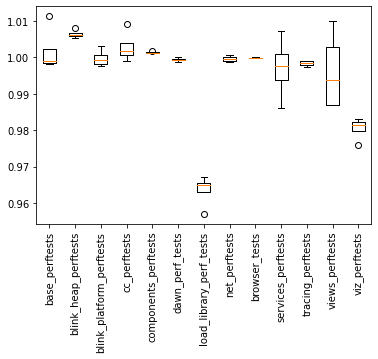

In [9]:
allTestMetrics = {}
for test in testComparisonsAverages:
    allTestMetrics[test] = {}
    for testInstance in testComparisonsAverages[test]:
        for metric in testInstance:
            if metric not in allTestMetrics[test]:
                allTestMetrics[test][metric] = []
            allTestMetrics[test][metric].append(testInstance[metric])
print(allTestMetrics["base_perftests"])
LoadMetrics = {}
for test in allTestMetrics:
    LoadMetrics[test] = allTestMetrics[test]["mem_uops_retired.all_loads"]
figure, axis = pyplot.subplots()
axis.boxplot(LoadMetrics.values())
axis.set_xticklabels(LoadMetrics.keys())
pyplot.xticks(rotation=90)
pyplot.show()

# Initial Impressions

Eliminating some test suites from this point will probably be easy for composing a good benchmarking pipeline. Suites like `load_library_perf_tests` are showing nothing even close to reliable performance, and I don't think I would really expect them to even just given the name. They're probably not CPU bound and instead testing performance on IO and what not which is not the point of these tests. Other test suites seem to be good candidates though like `base_perftests`, `blink_platform_perftests`, `cc_perftests`, `component_perftests`, `dawn_perf_tests`, `net_perftests` (although I need to dig into this one and see if it is testing CPU bound networking code with actually networking mocked out or if it is actually calling network stuff, but I would assume the former), `browser_tests`, and `tracing_perftests`.

There is also some more data needed on what would happen if we're able to remove a lot of the really noisy tests that aren't necessarily CPU bound. The rest of this notebook will probably be used to do analysis on that sort of stuff.

In [10]:
allTestRanges = {}
for testSuite in loadTestComparisons:
    testRanges = {}
    for testRun in loadTestComparisons[testSuite]:
        for test in testRun:
            if test not in testRanges:
                testRanges[test] = {}
            for metric in testRun[test]:
                if metric not in testRanges[test]:
                    testRanges[test][metric] = []
                testRanges[test][metric].append(testRun[test][metric])
    allTestRanges[testSuite] = testRanges

In [11]:
testSuiteIndividualAnalysis = "browser_tests"
individualTestsLoads = {}
individualTestsStores = {}
for test in allTestRanges[testSuiteIndividualAnalysis]:
    individualTestsLoads[test] = allTestRanges[testSuiteIndividualAnalysis][test]["mem_uops_retired.all_loads"]
    individualTestsStores[test] = allTestRanges[testSuiteIndividualAnalysis][test]["mem_uops_retired.all_stores"]

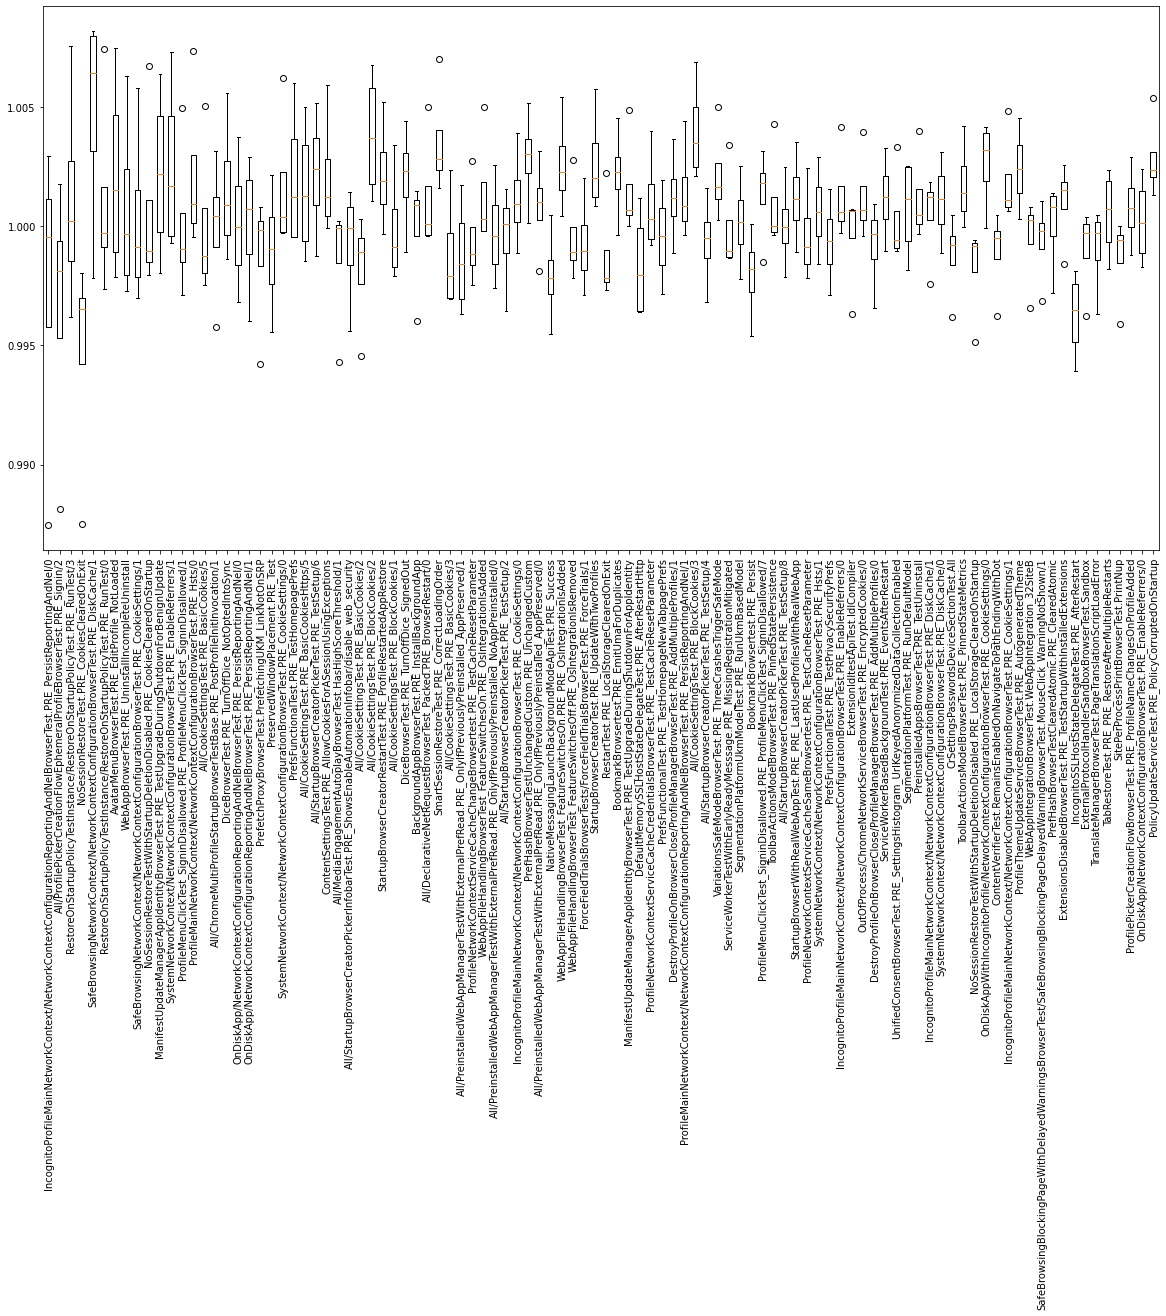

In [12]:
def rangeCompare(a,b):
    if (max(b[1]) - min(b[1])) > (max(a[1]) - min(a[1])):
        return -1
    return 1

sortedIndividualTestsLoads = sorted(individualTestsLoads.items(), key=cmp_to_key(rangeCompare), reverse=True)

outputIndividualTestsLoads = {}
for parts in sortedIndividualTestsLoads:
    outputIndividualTestsLoads[parts[0]] = parts[1]

displayPartition = {}
for test in outputIndividualTestsLoads:
    displayPartition[test] = outputIndividualTestsLoads[test]
    if len(displayPartition) == 100:
        break
figure, axis = pyplot.subplots()
axis.boxplot(displayPartition.values())
axis.set_xticklabels(displayPartition.keys())
figure.set_size_inches(20, 10)
pyplot.xticks(rotation=90)
pyplot.show()

A lot of the variability seems to be coming from just a few tests within these test suites. Next up I'm going to try cutting off the 10% of tests with the highest range and see how that impacts the overall performance of at least one of the test suites (probably the `base_perftests` suite and if I end up going in this direction, the other candidate test suites as well).

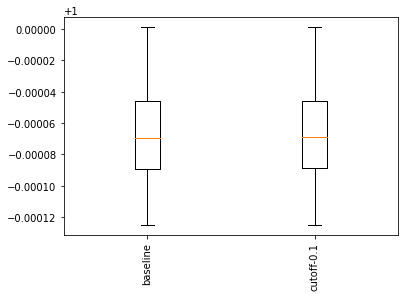

[0.9998749710075745, 0.9999235542170241, 1.0000012286818196, 0.999938490147861]


In [13]:
loadTestsCutoff = {}
counter = 0
for parts in sortedIndividualTestsLoads:
    if counter > 0 * len(sortedIndividualTestsLoads):
        loadTestsCutoff[parts[0]] = parts[1]
    counter += 1

runRelativeSpeedups = []
for test in loadTestsCutoff:
    for index,speedupValue in enumerate(loadTestsCutoff[test]):
        if index + 1 > len(runRelativeSpeedups):
            runRelativeSpeedups.append([])
        runRelativeSpeedups[index].append(speedupValue)

speedupsGeometricMeans = []
for speedupArray in runRelativeSpeedups:
    speedupsGeometricMeans.append(geometric_mean(speedupArray))

cutoffTestingPlotDict = {
    "baseline": allTestMetrics[testSuiteIndividualAnalysis]["mem_uops_retired.all_loads"],
    "cutoff-0.1": speedupsGeometricMeans
}

figure, axis = pyplot.subplots()
axis.boxplot(cutoffTestingPlotDict.values())
axis.set_xticklabels(cutoffTestingPlotDict.keys())
pyplot.xticks(rotation=90)
pyplot.show()

print(speedupsGeometricMeans)

Based on these results, cutting off the most variable tests definitely seems like it could be helpful. However, the threshold for different tests needs to be played around with a little bit. Some tests seem to benefit greatly from a pretty high threshold (eg `base_perftests` at 40%), while other tests don't seem to need that much cut off (eg `browser_perftests` that can still hit really low variability without any tests being cut off). Below is a list of tests that I'm planning on using along with the threshold that works well for that specific test:
```
base_perftests - 40%
components_perftests - 40%
browser_tests - 0%
```
The target for these cutoffs is to try and make a the run-to-run variability below 0.1%.

Tests suites excluded for not being able to meet the standard despite really high cutoffs:
```
blink_platform_perftests
cc_perftests
dawn_perf_tests
net_perftests*
tracing_perftests**
```
* `net_perftests` seems to only have a handful of tests in it
* `tracing_perftests` also seems to only have a handful of tests
Neither of these two test suites seem to have particularly good run to run variability.

Next up is to do a full comparison, comparing all of the selected test suites combined in regards to a baseline configuration and a filtered configuration with the x% of variable tests per suite taken out and ignored.

In [40]:
baselineAllTargetMetric = 'mem_uops_retired.all_loads'
baselineAllComparisons = {}
for testSuite in loadTestComparisons:
    for testSuiteInstance in loadTestComparisons[testSuite]:
        for individualTest in testSuiteInstance:
            if individualTest not in baselineAllComparisons:
                baselineAllComparisons[individualTest] = []
            baselineAllComparisons[individualTest].append(testSuiteInstance[individualTest][baselineAllTargetMetric])

baselineAllComparisonsArray = []
for i in range(0, len(baselineAllComparisons[next(iter(baselineAllComparisons))])):
    baselineAllComparisonsArray.append([])

for test in baselineAllComparisons:
    for index, dataPoint in enumerate(baselineAllComparisons[test]):
        baselineAllComparisonsArray[index].append(dataPoint)

baselineFinalData = []
for allTestsArray in baselineAllComparisonsArray:
    baselineFinalData.append(geometric_mean(allTestsArray))

print(baselineFinalData)

[0.9997631437350029, 0.9998189891408825, 1.0001225420437736, 0.9998512922680166]


# Full Baseline
Just concatenating all the tests from the individual suites seems to give some pretty decent results (pretty far within a 0.1% tolerance). Might just run with this, but I should probably at least test the test selection/exclusion of high variability tests method. That is the method that I am going to try next.

In [58]:
cutoffTargetMetric = "mem_uops_retired.all_loads"

def getTestsForSuite(suiteName):
    testsToReturn = {}
    for testSuiteInstance in loadTestComparisons[suiteName]:
        for individualTest in testSuiteInstance:
            if individualTest not in testsToReturn:
                testsToReturn[individualTest] = []
            testsToReturn[individualTest].append(testSuiteInstance[individualTest][cutoffTargetMetric])
    return testsToReturn

basePerftestComparisons = getTestsForSuite("base_perftests")
componentsPerftestsComparisons = getTestsForSuite("components_perftests")
browserTestsComparisons = getTestsForSuite("browser_tests")

basePerftestsCutoffThreshold = 0.4
componentsPerftestsCutoffThreshold = 0.6
# Ignoring the cutoff threshold for the browser tests since it is zero

basePerftestComparisonsSortedArray = sorted(basePerftestComparisons.items(), key=cmp_to_key(rangeCompare), reverse=True)
componentsPerftestsComparisonsSortedArray = sorted(componentsPerftestsComparisons.items(), key=cmp_to_key(rangeCompare), reverse=True)

print("Number of tests in base_perftests:{count}".format(count=len(basePerftestComparisons)))
print("Number of tests for components_perftests:{count}".format(count=len(componentsPerftestsComparisons)))

basePerftestComparisonsSorted = {}
basePerftestComparisonsProcessed = 0
for parts in basePerftestComparisonsSortedArray:
    if basePerftestComparisonsProcessed > basePerftestsCutoffThreshold * len(basePerftestComparisonsSortedArray):
        basePerftestComparisonsSorted[parts[0]] = parts[1]
    basePerftestComparisonsProcessed += 1

componentsPerftestComparisonsSorted = {}
componentsPerftestComparisonsProcessed = 0
for parts in componentsPerftestsComparisonsSortedArray:
    if componentsPerftestComparisonsProcessed > componentsPerftestsCutoffThreshold * len(componentsPerftestsComparisonsSortedArray):
        componentsPerftestComparisonsSorted[parts[0]] = parts[1]
    componentsPerftestComparisonsProcessed += 1

print("Number of tests for base_perftests after processing:{count}".format(count=len(basePerftestComparisonsSorted)))
print("Number of tests for components_perftests are processing:{count}".format(count=len(componentsPerftestComparisonsSorted)))

# putting all the tests together now
cutoffAllTests = {}
for test in basePerftestComparisonsSorted:
    cutoffAllTests[test] = basePerftestComparisonsSorted[test]
for test in componentsPerftestComparisonsSorted:
    cutoffAllTests[test] = componentsPerftestComparisonsSorted[test]
for test in browserTestsComparisons:
    cutoffAllTests[test] = browserTestsComparisons[test]

cutoffAllTestsArray = []
for i in range(0, len(cutoffAllTests[next(iter(cutoffAllTests))])):
    cutoffAllTestsArray.append([])

for test in cutoffAllTests:
    for index, individualValue in enumerate(cutoffAllTests[test]):
        cutoffAllTestsArray[index].append(individualValue)

cutoffFinalResults = []
for cutoffResultsArray in cutoffAllTestsArray:
    cutoffFinalResults.append(geometric_mean(cutoffResultsArray))
print(cutoffFinalResults)

Number of tests in base_perftests:264
Number of tests for components_perftests:70
Number of tests for base_perftests after processing:158
Number of tests for components_perftests are processing:27
[0.9998848821628742, 0.9999303628024309, 1.000001627654484, 0.9999428567966894]


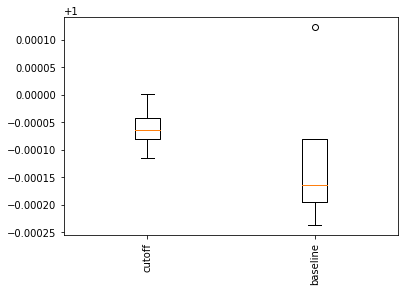

In [59]:
techniqueComparisonDict = {
    "cutoff": cutoffFinalResults,
    "baseline": baselineFinalData
}

figure, axis = pyplot.subplots()
axis.boxplot(techniqueComparisonDict.values())
axis.set_xticklabels(techniqueComparisonDict.keys())
pyplot.xticks(rotation=90)
pyplot.show()

# Conclusion

The cutoff method seems to work extremely well and since we can specify individual tests to run, it should make an even faster benchmarking  pipeline which should be pretty nice, especially if I need to run everything singlethreaded (but I will be testing to see if I can run stuff multithreaded). The overall spread seems to be less than 0.02% which means that detecting differences of about 0.1% should be pretty easy and they should stick out pretty well. Just need to get the test names that I'm using exported and get everything ready to run actual benchmarks.

In [62]:
basePerftestsCutoffList = []
for test in basePerftestComparisonsSorted:
    basePerftestsCutoffList.append(test)
basePerftestsOutputDict = {
    "executable": "/path/to/executable",
    "tests": basePerftestsCutoffList
}
print(json.dumps(basePerftestsOutputDict, indent=4))

{
    "executable": "/path/to/executable",
    "tests": [
        "ThreadPoolPerfTest.PostRunNoOpTasksManyThreads",
        "PartitionAllocMemoryAllocationPerfTest.MultiBucketWithFree/21",
        "PartitionAllocMemoryAllocationPerfTest.DirectMapped/14",
        "PartitionAllocMemoryAllocationPerfTest.DirectMapped/16",
        "PartitionAllocMemoryAllocationPerfTest.SingleBucketWithFree/23",
        "PartitionAllocMemoryAllocationPerfTest.SingleBucketWithFree/2",
        "JobPerfTest.NoOpDisruptedWorkDynamicAssignment",
        "PartitionAllocMemoryAllocationPerfTest.MultiBucketWithFree/20",
        "PartitionAllocMemoryAllocationPerfTest.MultiBucketWithFree/23",
        "JobPerfTest.BusyWaitWorkLoopAround",
        "All/SequenceManagerPerfTest.PostImmediateTasksFromTwoThreads_OneQueue/3",
        "PartitionAllocMemoryAllocationPerfTest.SingleBucket/0",
        "ThreadPoolPerfTest.PostRunBusyTasksManyThreads",
        "PartitionAllocMemoryAllocationPerfTest.SingleBucketWithFree/8",
   

In [64]:
componentsPerftestsCutoffList = []
for test in componentsPerftestComparisonsSorted:
    componentsPerftestsCutoffList.append(test)
componentsPerftestsOutputDict = {
    "executable": "/path/to/executable",
    "tests": componentsPerftestsCutoffList
}
print(json.dumps(componentsPerftestsOutputDict, indent=4))

{
    "executable": "/path/to/executable",
    "tests": [
        "ProtoDBPerfTest.LoadEntriesSingle_OnePrefix_DifferingNumDBs_Medium",
        "ProtoDBPerfTest.LoadEntriesMulti_OnePrefix_DifferingNumDBs_Medium",
        "HQPPerfTestOnePopularURL.Backspacing",
        "ProtoDBPerfTest.LoadEntriesSingle_SkipReadCache_Medium",
        "ProtoDBPerfTest.LoadEntriesMulti_DifferingNumDBs_Small",
        "HQPPerfTestOnePopularURL.Typing",
        "ProtoDBPerfTest.LoadEntriesSingle_OnePrefix_DifferingNumDBs_SkipReadCache_Large",
        "ProtoDBPerfTest.DistributionTestSmall_ManyEntries_Multi",
        "ProtoDBPerfTest.LoadEntriesSingle_DifferingNumDBs_SkipReadCache_Large",
        "ProtoDBPerfTest.LoadEntriesMulti_Medium",
        "ProtoDBPerfTest.DistributionTestSmall_FewEntries_Single",
        "ProtoDBPerfTest.LoadEntriesSingle_DifferingNumDBs_Large",
        "ProtoDBPerfTest.LoadEntriesMulti_SkipReadCache_Large",
        "ProtoDBPerfTest.LoadEntriesSingle_OnePrefix_Large",
        "ProtoD